In [16]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim

import matplotlib.pyplot as plt


In [22]:
def adversarial_attack(input_data, model, labels, epsilon) :
  alpha = 0.2
  input_data.requires_grad = True

  outputs, _ = model(input_data)
  loss_func = nn.CrossEntropyLoss()
  loss = loss_func(outputs, labels)

  model.zero_grad()
  loss.backward()

  perturbation = alpha * input_data.grad.data.sign()
  perturbed_data = input_data + perturbation
  perturbed_data = torch.clamp(perturbed_data, input_data-epsilon, input_data+epsilon)

  return perturbed_data


In [4]:
train_data = datasets.MNIST(root = 'data', train = True, transform = transforms.ToTensor(), download = True)

test_data = datasets.MNIST(root = 'data', train = False, transform = transforms.ToTensor())

print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [5]:
loaders = {
    'train' : DataLoader(train_data, batch_size = 100, shuffle = True),

    'test' :  DataLoader(test_data, batch_size = 100, shuffle = True)
}

In [6]:
class LinearModel(nn.Module):
  def __init__(self):
    super (LinearModel, self).__init__()

    self.flatten = nn.Flatten()

    self.out1 = nn.Linear(28 * 28, 128)
    self.activation1 = nn.ReLU()
    self.out2 = nn.Linear(128, 10)
    self.activation2 = nn.Sigmoid()

  def forward(self, x):
      x = self.flatten(x)
      x = self.out1(x)
      x = self.activation1(x)
      x = self.out2(x)
      output = self.activation2(x)
      return output, x

linear_model = LinearModel();
print(linear_model)

LinearModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (out1): Linear(in_features=784, out_features=128, bias=True)
  (activation1): ReLU()
  (out2): Linear(in_features=128, out_features=10, bias=True)
  (activation2): Sigmoid()
)


In [7]:
loss_function = nn.CrossEntropyLoss()

In [8]:
optimizer = optim.Adam(linear_model.parameters(), lr = 0.01)

In [9]:
num_epochs = 5

def train(num_epochs, linear, loaders):

  linear.train()

  total_step = len(loaders['train'])

  for epoch in range(num_epochs) :
    for i, (images, labels) in enumerate(loaders['train']):

      b_x = images
      b_y = labels

      output = linear(b_x)[0]
      loss = loss_function(output, b_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
train(num_epochs, linear_model, loaders)

Epoch [1/5], Step [100/600], Loss: 1.5695
Epoch [1/5], Step [200/600], Loss: 1.5455
Epoch [1/5], Step [300/600], Loss: 1.5249
Epoch [1/5], Step [400/600], Loss: 1.5550
Epoch [1/5], Step [500/600], Loss: 1.5047
Epoch [1/5], Step [600/600], Loss: 1.5305
Epoch [2/5], Step [100/600], Loss: 1.4818
Epoch [2/5], Step [200/600], Loss: 1.4882
Epoch [2/5], Step [300/600], Loss: 1.5222
Epoch [2/5], Step [400/600], Loss: 1.4826
Epoch [2/5], Step [500/600], Loss: 1.5062
Epoch [2/5], Step [600/600], Loss: 1.4985
Epoch [3/5], Step [100/600], Loss: 1.4921
Epoch [3/5], Step [200/600], Loss: 1.4855
Epoch [3/5], Step [300/600], Loss: 1.4978
Epoch [3/5], Step [400/600], Loss: 1.5034
Epoch [3/5], Step [500/600], Loss: 1.4883
Epoch [3/5], Step [600/600], Loss: 1.5115
Epoch [4/5], Step [100/600], Loss: 1.4886
Epoch [4/5], Step [200/600], Loss: 1.5140
Epoch [4/5], Step [300/600], Loss: 1.4997
Epoch [4/5], Step [400/600], Loss: 1.5070
Epoch [4/5], Step [500/600], Loss: 1.5052
Epoch [4/5], Step [600/600], Loss:

In [33]:
def test():
  linear_model.eval()
  correct = 0
  total = 0

  for images, labels in loaders['test']:
        perturbed_images = adversarial_attack(images, linear_model, labels, 0.1)
        test_output = linear_model(perturbed_images)[0]
        _, pred_y = torch.max(test_output, 1)

  accuracy = (pred_y == labels).sum().item() / float(labels.size(0))

  print('Test Accuracy: %.2f' % accuracy)
test()

Test Accuracy: 0.28


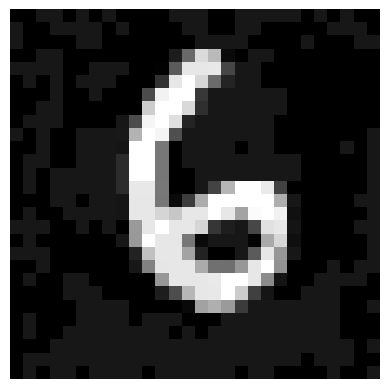

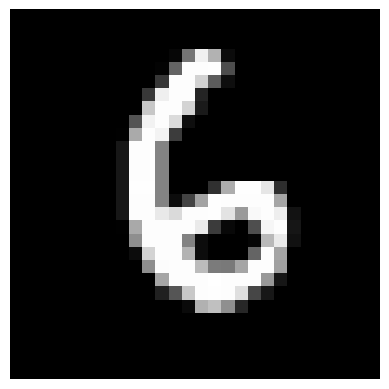

In [39]:
for images, labels in loaders['test']:
    perturbed_images = adversarial_attack(images, linear_model, labels, 0.05)
    break

image_array1 = perturbed_images[0].detach().squeeze().numpy()
image_array2 = images[0].detach().squeeze().numpy()

plt.axis('off')
plt.imshow(image_array1, cmap='gray')
plt.show()
plt.axis('off')
plt.imshow(image_array2, cmap='gray')
plt.show()